In [19]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=1000)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=1000)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

from dotenv import load_dotenv
load_dotenv()

import os
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_TRACING'] = "true"
os.environ['LANGCHAIN_PROJECT'] = "ReAct-agent"


In [2]:
## custom functions

def multiply(a:int, b:int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a*b

def add(a:int, b:int) -> int:
    """Add a and b.

    Args:
        a: first int
        b: second int
    """
    return a+b

def divide(a:int, b:int) -> float:
    """divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a/b



In [20]:
## tavily search tool

from langchain_tavily import TavilySearch

tavily = TavilySearch()

# tavily.invoke("Give me latest Gen AI news for June 27,2025")

In [21]:
tools = [arxiv,wiki,tavily,add,multiply,divide]

In [13]:
# initializze my LLM tool

from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI

# llm_groq = ChatGroq(model="qwen-qwq-32b")
llm_groq = ChatOpenAI(model="gpt-4o")

llm_with_tools = llm_groq.bind_tools(tools=tools)

In [22]:
from pprint import pprint
from langchain_core.messages import HumanMessage, AIMessage

llm_with_tools.invoke([HumanMessage(content="What is the recent AI news for today")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '48xwv07h1', 'function': {'arguments': '{"query":"AI news","time_range":"day","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 303, 'prompt_tokens': 1386, 'total_tokens': 1689, 'completion_time': 0.747866596, 'prompt_time': 0.073293167, 'queue_time': 0.262565322, 'total_time': 0.821159763}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_98b01f25b2', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--33cffa9b-ffca-49ad-aba2-5064907c5de8-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'AI news', 'time_range': 'day', 'topic': 'news'}, 'id': '48xwv07h1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1386, 'output_tokens': 303, 'total_tokens': 1689})

In [23]:
llm_with_tools.invoke([HumanMessage(content="What is the latest AI news for today")]).tool_calls

[{'name': 'tavily_search',
  'args': {'query': 'latest AI news', 'time_range': 'day', 'topic': 'news'},
  'id': 'ymw4bxqa9',
  'type': 'tool_call'}]

In [24]:
## state schema

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

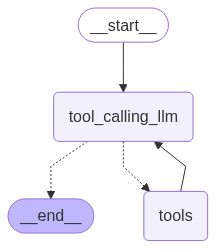

In [26]:
# entire Chatbot with Langgraph

from IPython.display import Image,display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm", tools_condition
)
builder.add_edge("tools","tool_calling_llm")

graph = builder.compile()

# view
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
messages = graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for today, and add 5 and 10 and then multiply by 10")})

for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for today, and add 5 and 10 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (f6sjd5str)
 Call ID: f6sjd5str
  Args:
    query: AI news
    search_depth: advanced
    time_range: day
    topic: news
  add (g6wth2qfs)
 Call ID: g6wth2qfs
  Args:
    a: 5
    b: 10
  multiply (mqbs4xwep)
 Call ID: mqbs4xwep
  Args:
    a: 15
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.businessinsider.com/sc/ai-desktops-make-workers-productive", "title": "AI is helping small businesses increase productivity. Here's a look inside the computing hardware helping power it. - Business Insider", "score": 0.60498303, "published_date": 

In [28]:
messages = graph.invoke({"messages":HumanMessage(content="What is machine learning")})

for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (gmjpe66r4)
 Call ID: gmjpe66r4
  Args:
    query: machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML finds application in many fields, including natural language processing, computer vision, speech recognition, email filterin

In [29]:
messages = graph.invoke({"messages":HumanMessage(content="What is 12 plus 13")})

for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What is 12 plus 13
================================== Ai Message ==================================
Tool Calls:
  add (mktyhescz)
 Call ID: mktyhescz
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

12 plus 13 equals 25.


In [30]:
messages = graph.invoke({"messages":HumanMessage(content="Add that number to 25")})

for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

Add that number to 25
================================== Ai Message ==================================

To proceed, I need to know which number you'd like to add to 25. Could you please specify the number you'd like to use?


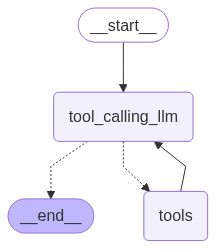

In [31]:
# entire Chatbot with Langgraph

from IPython.display import Image,display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

# node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm", tools_condition
)
builder.add_edge("tools","tool_calling_llm")

memory = MemorySaver() ## memory saver initialiation
graph = builder.compile(memory)

# view
display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
config = {"configurable":{"thread_id":"1"}}
messages = graph.invoke({"messages":HumanMessage(content="What is 12 plus 13")},config=config)

for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What is 12 plus 13
================================== Ai Message ==================================
Tool Calls:
  add (atca077m9)
 Call ID: atca077m9
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The result of 12 plus 13 is **25**.


In [33]:
config = {"configurable":{"thread_id":"1"}}
messages = graph.invoke({"messages":HumanMessage(content="Add that number to 125")},config=config)

for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What is 12 plus 13
================================== Ai Message ==================================
Tool Calls:
  add (atca077m9)
 Call ID: atca077m9
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The result of 12 plus 13 is **25**.
================================ Human Message =================================

Add that number to 125
================================== Ai Message ==================================
Tool Calls:
  add (nsvppa8v2)
 Call ID: nsvppa8v2
  Args:
    a: 25
    b: 125
================================= Tool Message =================================
Name: add

150
================================== Ai Message ==================================

The result of adding 25 and 125 is **150**. How else can I assist you today?


In [34]:
config = {"configurable":{"thread_id":"1"}}
messages = graph.invoke({"messages":HumanMessage(content="Multiply that by 150")},config=config)

for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What is 12 plus 13
================================== Ai Message ==================================
Tool Calls:
  add (atca077m9)
 Call ID: atca077m9
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The result of 12 plus 13 is **25**.
================================ Human Message =================================

Add that number to 125
================================== Ai Message ==================================
Tool Calls:
  add (nsvppa8v2)
 Call ID: nsvppa8v2
  Args:
    a: 25
    b: 125
================================= Tool Message =================================
Name: add

150
================================== Ai Message ==================================

The result of adding 25 and 125 is **150**. How else can I assist you today?
=======